**Time delay dynamics:**
$x(t) = f(x(t), N(x(t-\tau)))$

In [4]:
from helpers.shared_imports import *
%matplotlib inline

In [5]:
from helpers.integrate import Controller, d_state_bebop, mass_bebop, simulate_system_delay, get_unbiased_controller, get_stabilised_controller
from helpers.vis import trajectory_plot_compare
from helpers.optimality_eval import get_equilibrium

In [6]:
pkl_name = 'power_bebop_h04_n0100.pkl'

model_path = 'models_pickled/bebop_power/'
nn_controller_orig = Controller(path_to_pickle=os.path.join(model_path, pkl_name))

equ_point = get_equilibrium(nn_controller_orig)
nn_controller = get_unbiased_controller(nn_controller_orig, equ_point) # stick to unbiased controller

In [7]:
data_path = 'datasets/bebop_power.npy'
dataset = np.load(data_path)

In [8]:
state_idx = {'time':0, 'x':1, 'vx':2, 'z':3, 'vz':4, 'theta':5, 'u1':6, 'u2':7}
state_indices = [1,2,3,4,5]

In [9]:
traj_idx = 2
traj_optimal = dataset[traj_idx]
initial_state = traj_optimal[0, state_indices]
initial_state

array([ 8.67255051, -0.88581217,  7.88085268, -0.61839704,  0.8359702 ])

**Find critical time delay**

We find that after a certain time delay $\tau$, oscillations appear during hovering.

The actual manoeuvre remains close to the optimal one.

Ofcourse when $\tau$ exceeds a large value (e.g. 0.2s), the manoeuvre is also affected.

Below we use `scipy.integrate.odeint` with the controls kept constant between time steps but delayed.
We do not find any loss of accuracy compared with using a delayed differential equation solver such as `PyDDE`.

There is a version of the function below that uses `PyDDE`: `simulate_system_dde()` but it is much, much slower.

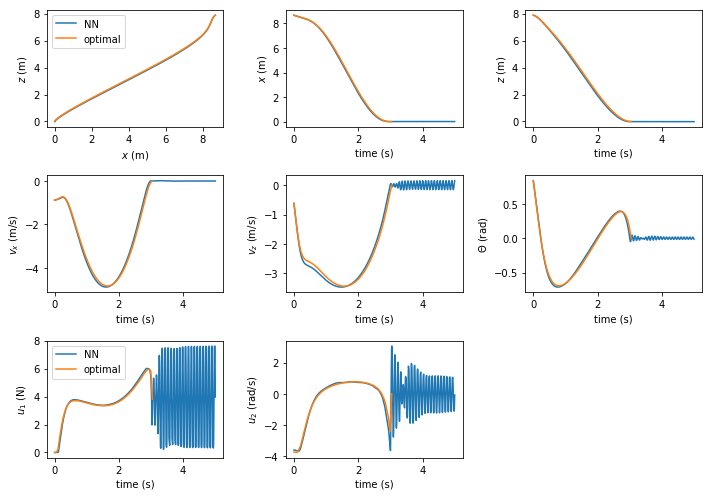

In [10]:
# time delay is delay_step*dt
delay_step = 22 # critical time delay for this NN

traj_sim = simulate_system_delay(
                nn_controller, 
                d_state_bebop, 
                initial_state, 
                mass=mass_bebop, 
                dt=0.001, 
                max_time=5.0,
                delay_step=delay_step)

trajectory_plot_compare(traj_optimal, traj_sim, label1='optimal', label2='NN')
plt.show()

**Augment NN with PD controller**

To overcome the effect of delays, we augment the control close to the target with a proportional derivative (PD) controller.

The controls from the NN and PD controller are weighted based on distance from the target.

See `get_stabilised_controller` for more details.

In [11]:
nn_controller_pd = get_stabilised_controller(nn_controller_orig, equ_point)

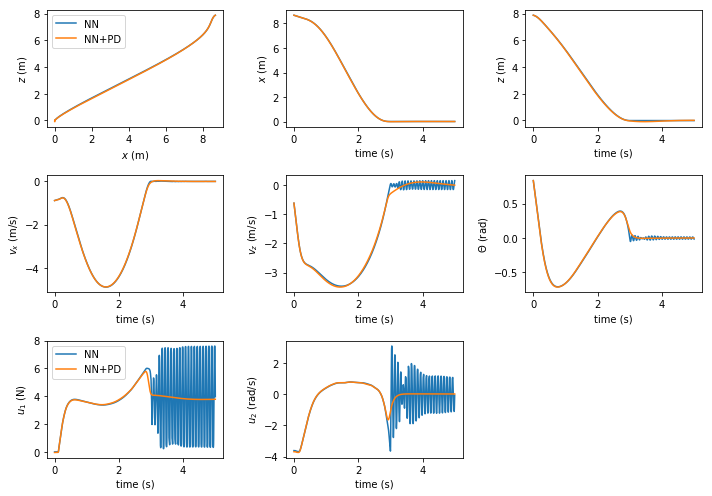

In [12]:
traj_sim_pd = simulate_system_delay(
                nn_controller_pd, 
                d_state_bebop, 
                initial_state, 
                mass=mass_bebop, 
                dt=0.001, 
                max_time=5.0,
                delay_step=delay_step)

trajectory_plot_compare(traj_sim_pd, traj_sim, label1='NN+PD', label2='NN')
plt.show()

We can now handle delays up to 0.1s.

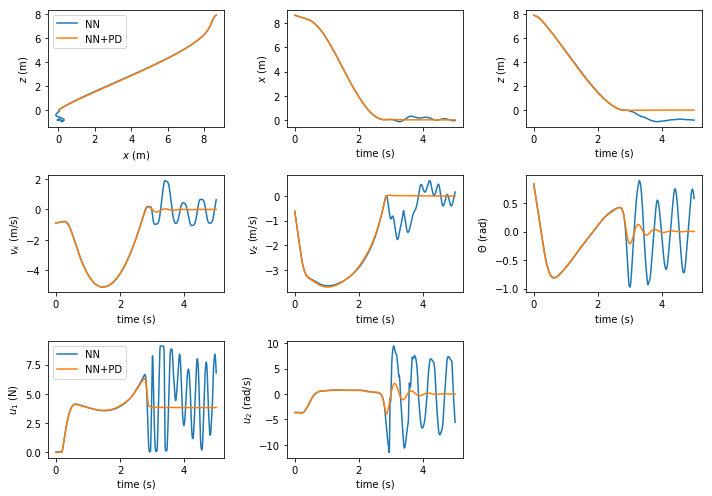

In [13]:
delay_step = 100 # 0.1s

traj_sim = simulate_system_delay(
                nn_controller, 
                d_state_bebop, 
                initial_state, 
                mass=mass_bebop, 
                dt=0.001, 
                max_time=5.0,
                delay_step=delay_step)

traj_sim_pd = simulate_system_delay(
                nn_controller_pd, 
                d_state_bebop, 
                initial_state, 
                mass=mass_bebop, 
                dt=0.001, 
                max_time=5.0,
                delay_step=delay_step)

trajectory_plot_compare(traj_sim_pd, traj_sim, label1='NN+PD', label2='NN')
plt.show()